[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


 80%|████████  | 4/5 [01:10<00:16, 16.39s/it]

Error parsing RGVK Dagestan: HTTPSConnectionPool(host='rgvktv.ru', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: EE certificate key too weak (_ssl.c:1006)')))


100%|██████████| 5/5 [01:23<00:00, 16.74s/it]


Collected 128 news items

Exploratory Data Analysis:
Total news items: 128
Unique sources: 18
Total federal districts: 5
Potential incidents detected: 8 (6.2%)

News items by Federal District:
  Northwestern Federal District: 37
  Volga Federal District: 27
  Central Federal District: 22
  Southern Federal District: 22
  North Caucasus Federal District: 20

Top sources by number of news items:
  Pobeda 26: 10
  78.ru: 10
  LenTV24: 10
  29.ru: 10
  161.ru: 10
  Business Online: 10
  Tatar-inform: 9
  Kuban 24: 9
  Makhachkalinskie Izvestia: 8
  Nizhegorodskaya Pravda: 8

Potential incidents by district:
  Southern Federal District: 4 (18.2%)
  Central Federal District: 2 (9.1%)
  North Caucasus Federal District: 2 (10.0%)
  Northwestern Federal District: 0 (0.0%)
  Volga Federal District: 0 (0.0%)

Most common words in headlines:
  новости: 11
  марта: 5
  осьмино: 5
  завершается: 5
  строительство: 5
  временного: 5
  моста: 5
  сабу: 5
  россии: 4
  путин: 4
  прекращении: 4
  назад

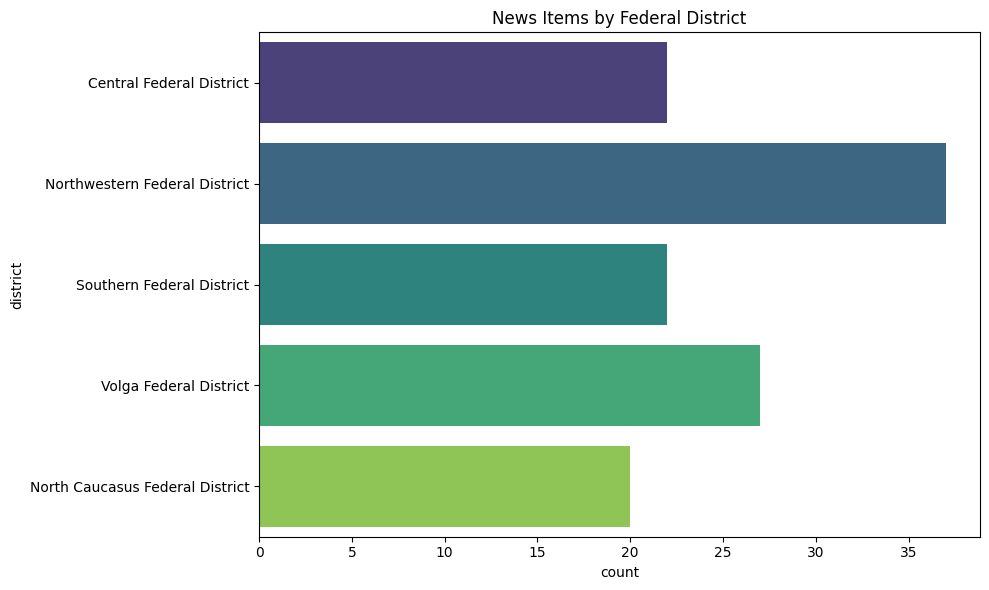

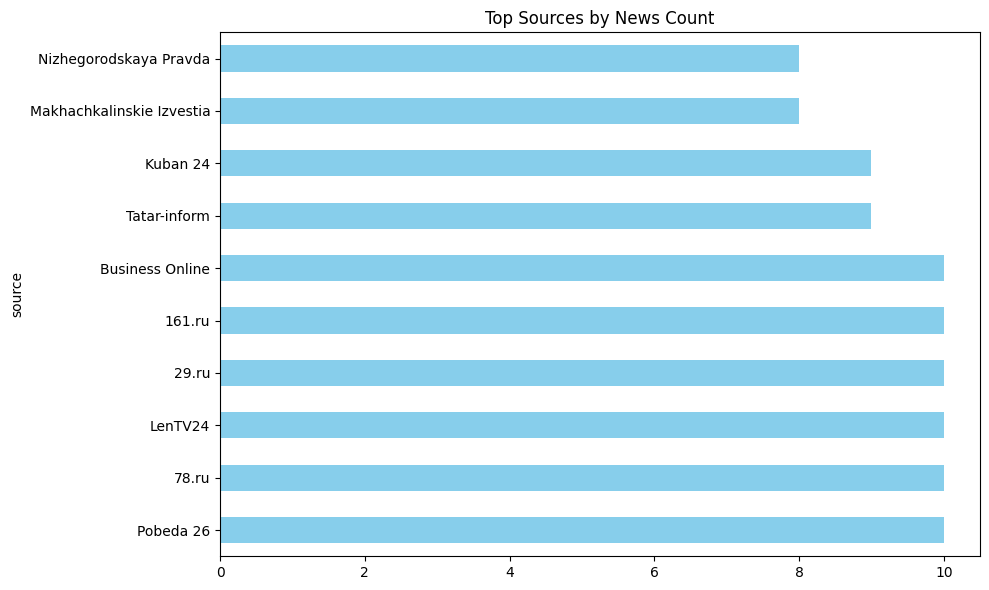

<Figure size 1000x600 with 0 Axes>

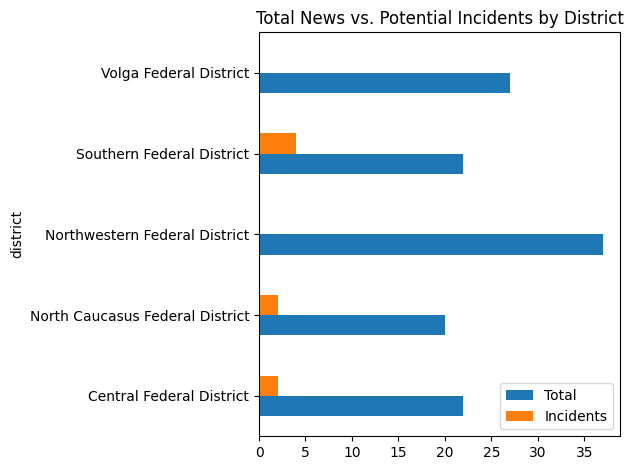

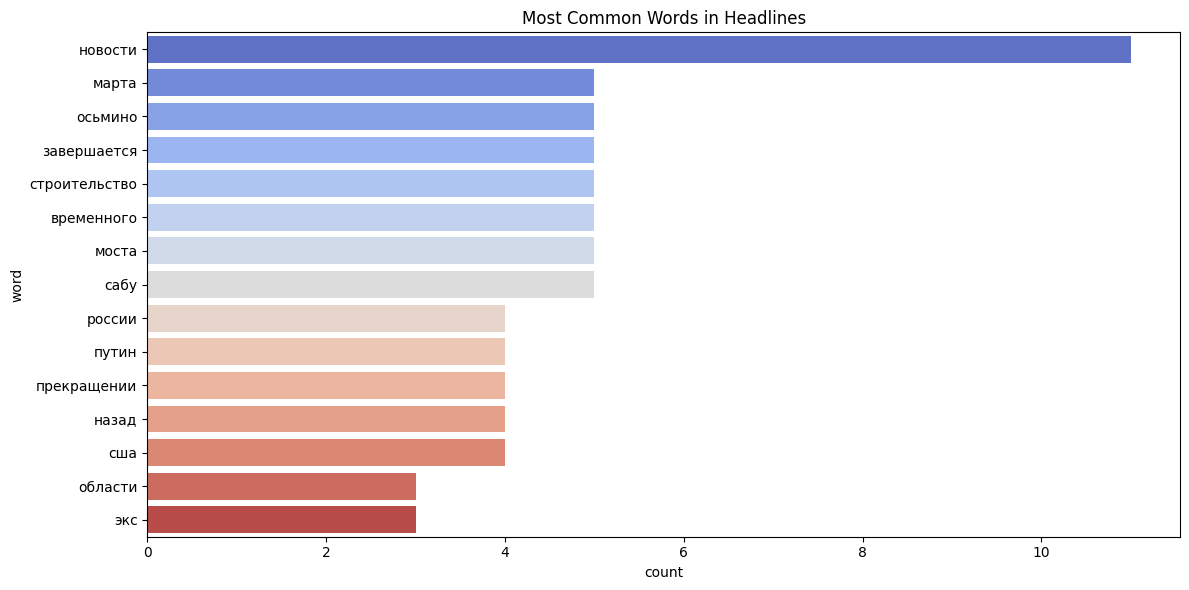

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import time
import random
from urllib.parse import urlparse
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK data
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Define sources from different federal districts
sources = {
    "Central Federal District": {
        "RIAMO": "https://riamo.ru/",
        "MK": "https://mk.ru/",
        "Podmoskovye Segodnya": "https://mosregtoday.ru/",
        "Moyo! Online": "https://moe-online.ru/",
        "RIA Voronezh": "https://riavrn.ru/"
    },
    "Northwestern Federal District": {
        "Fontanka": "https://www.fontanka.ru/",
        "78.ru": "https://78.ru/",
        "LenTV24": "https://lentv24.ru/",
        "Pravda Severa": "https://pravdasevera.ru/",
        "29.ru": "https://29.ru/"
    },
    "Southern Federal District": {
        "161.ru": "https://161.ru/",
        "Don24": "https://don24.ru/",
        "Yuga.ru": "https://www.yuga.ru/",
        "Kuban 24": "https://kuban24.tv/"
    },
    "Volga Federal District": {
        "Nizhegorodskaya Pravda": "https://pravda-nn.ru/",
        "NN.ru": "https://nn.ru/",
        "Tatar-inform": "https://www.tatar-inform.ru/",
        "Business Online": "https://www.business-gazeta.ru/"
    },
    "North Caucasus Federal District": {
        "Stavropolskaya Pravda": "https://stapravda.ru/",
        "Pobeda 26": "https://pobeda26.ru/",
        "RGVK Dagestan": "https://rgvktv.ru/",
        "Makhachkalinskie Izvestia": "https://md-gazeta.ru/"
    }
}

# User agent to mimic browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# Function to parse news (site-specific parsers)
def parse_news(source_name, url):
    try:
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code != 200:
            return []

        soup = BeautifulSoup(response.text, 'html.parser')
        news_items = []

        # Different parsing logic based on source
        if source_name == "RIAMO":
            articles = soup.select('.b-item-md')[:10]
            for article in articles:
                title_elem = article.select_one('.b-item-md__title')
                title = title_elem.text.strip() if title_elem else "No title"
                link = title_elem.get('href') if title_elem else ""
                if not link.startswith('http'):
                    link = url + link.lstrip('/')
                date_elem = article.select_one('.b-item-md__date')
                date = date_elem.text.strip() if date_elem else "No date"
                news_items.append({
                    'source': source_name,
                    'title': title,
                    'link': link,
                    'date': date,
                    'text': ""  # Would require opening each article
                })

        elif "fontanka" in url.lower():
            articles = soup.select('.HHrTR, .material-excerpt')[:10]
            for article in articles:
                title_elem = article.select_one('a')
                title = title_elem.text.strip() if title_elem else "No title"
                link = title_elem.get('href') if title_elem else ""
                if not link.startswith('http'):
                    link = "https://www.fontanka.ru" + link
                date_elem = article.select_one('.time')
                date = date_elem.text.strip() if date_elem else "No date"
                news_items.append({
                    'source': source_name,
                    'title': title,
                    'link': link,
                    'date': date,
                    'text': ""
                })

        # Generic parser for other sources
        else:
            # Look for common article structures
            articles = soup.select('article, .news-item, .article, .news, .item, .entry, .post, div[class*="news"], div[class*="article"]')[:10]
            if not articles:
                # Try finding links in the main content area
                articles = soup.select('a[href*="news"], a[href*="article"], a[href*="story"]')[:10]

            for article in articles:
                # Try to find title
                title_elem = article.select_one('h2, h3, h4, .title, [class*="title"], [class*="headline"]')
                if not title_elem:
                    title_elem = article
                title = title_elem.text.strip() if hasattr(title_elem, 'text') else "No title"

                # Try to find link
                link_elem = article.select_one('a') if article.name != 'a' else article
                link = link_elem.get('href', '') if link_elem else ""
                if link and not link.startswith('http'):
                    parsed_url = urlparse(url)
                    base_url = f"{parsed_url.scheme}://{parsed_url.netloc}"
                    link = base_url + link if link.startswith('/') else base_url + '/' + link

                # Try to find date
                date_elem = article.select_one('[class*="date"], [class*="time"], time')
                date = date_elem.text.strip() if date_elem and hasattr(date_elem, 'text') else "No date"

                if title and title != "No title" and len(title) > 5:  # Filter out non-article elements
                    news_items.append({
                        'source': source_name,
                        'title': title,
                        'link': link,
                        'date': date,
                        'text': ""
                    })

        return news_items[:10]  # Return up to 10 news items

    except Exception as e:
        print(f"Error parsing {source_name}: {e}")
        return []

# Collect news from all sources
all_news = []
print("Collecting news from regional sources...")

for district, district_sources in tqdm(sources.items()):
    for source_name, url in district_sources.items():
        news_items = parse_news(source_name, url)
        for item in news_items:
            item['district'] = district
        all_news.extend(news_items)
        time.sleep(random.uniform(1, 3))  # Be nice to the servers

# Convert to DataFrame
df = pd.DataFrame(all_news)
print(f"Collected {len(df)} news items")

# Basic cleaning
df['title_length'] = df['title'].apply(lambda x: len(x))
df['has_link'] = df['link'].apply(lambda x: len(x) > 0)

# Extract possible incident indicators from titles
incident_keywords = [
    'авария', 'пожар', 'погиб', 'умер', 'смерть', 'убийство', 'убил', 'нарушени',
    'ДТП', 'катастроф', 'происшеств', 'несчастн', 'случай', 'чрезвычайн',
    'взрыв', 'разруш', 'прорыв', 'сгорел', 'столкнов', 'наводнени', 'потоп',
    'эвакуац', 'обрушени'
]

def is_potential_incident(title):
    title_lower = title.lower()
    return any(keyword in title_lower for keyword in incident_keywords)

df['potential_incident'] = df['title'].apply(is_potential_incident)

# Extract most common words in titles
def extract_common_words(df):
    titles = ' '.join(df['title'].str.lower())
    words = re.findall(r'\b[а-яёa-z]{3,}\b', titles)
    russian_stopwords = stopwords.words('russian')
    english_stopwords = stopwords.words('english')
    all_stopwords = set(russian_stopwords + english_stopwords)
    filtered_words = [word for word in words if word not in all_stopwords]
    return Counter(filtered_words).most_common(20)

# Save the dataframe
df.to_csv('regional_news.csv', index=False)

# Perform EDA
print("\nExploratory Data Analysis:")

# Basic statistics
total_sources = df['source'].nunique()
total_districts = df['district'].nunique()
total_incidents = df['potential_incident'].sum()

print(f"Total news items: {len(df)}")
print(f"Unique sources: {total_sources}")
print(f"Total federal districts: {total_districts}")
print(f"Potential incidents detected: {total_incidents} ({total_incidents/len(df)*100:.1f}%)")

# News by district
district_counts = df['district'].value_counts()
print("\nNews items by Federal District:")
for district, count in district_counts.items():
    print(f"  {district}: {count}")

# Sources with most news
source_counts = df['source'].value_counts().head(10)
print("\nTop sources by number of news items:")
for source, count in source_counts.items():
    print(f"  {source}: {count}")

# Potential incidents by district
incidents_by_district = df.groupby('district')['potential_incident'].sum().sort_values(ascending=False)
print("\nPotential incidents by district:")
for district, count in incidents_by_district.items():
    total = district_counts[district]
    print(f"  {district}: {count} ({count/total*100:.1f}%)")

# Most common words
common_words = extract_common_words(df)
print("\nMost common words in headlines:")
for word, count in common_words:
    print(f"  {word}: {count}")

# Create visualizations
plt.figure(figsize=(10, 6))
sns.countplot(y='district', data=df, palette='viridis')
plt.title('News Items by Federal District')
plt.tight_layout()
plt.savefig('news_by_district.png')

plt.figure(figsize=(10, 6))
source_counts.plot(kind='barh', color='skyblue')
plt.title('Top Sources by News Count')
plt.tight_layout()
plt.savefig('top_sources.png')

plt.figure(figsize=(10, 6))
df_district_incidents = pd.DataFrame({
    'Total': district_counts,
    'Incidents': incidents_by_district
})
df_district_incidents.plot(kind='barh')
plt.title('Total News vs. Potential Incidents by District')
plt.tight_layout()
plt.savefig('incidents_by_district.png')

plt.figure(figsize=(12, 6))
words_df = pd.DataFrame(common_words, columns=['word', 'count'])
sns.barplot(x='count', y='word', data=words_df.head(15), palette='coolwarm')
plt.title('Most Common Words in Headlines')
plt.tight_layout()
plt.savefig('common_words.png')

print("\nEDA completed! Visualizations saved to disk.")
print("NOTE: This is a basic parser and EDA. For production use, site-specific parsers would need to be developed for each news source.")

# Sample function for categorizing news (would be enhanced with LLM)
def categorize_with_keywords(title):
    incident_score = sum(1 for keyword in incident_keywords if keyword in title.lower())
    return "Incident" if incident_score > 0 else "Not Incident"

df['category'] = df['title'].apply(categorize_with_keywords)
incident_percentage = (df['category'] == 'Incident').mean() * 100

print(f"\nPercentage of news categorized as incidents: {incident_percentage:.1f}%")

# Example of how this would connect to location parsing with LLM
def extract_location_with_llm(text):
    # In a real implementation, this would use an LLM API
    # For this example, we'll just simulate it with a simple regex for Russian city names
    common_cities = ['Москва', 'Санкт-Петербург', 'Воронеж', 'Нижний Новгород', 'Казань',
                     'Ростов', 'Краснодар', 'Ставрополь', 'Махачкала', 'Архангельск']

    for city in common_cities:
        if city in text:
            return city
    return None

df['location'] = df['title'].apply(extract_location_with_llm)
location_found = df['location'].notnull().sum()

print(f"Location extracted from {location_found} news items ({location_found/len(df)*100:.1f}%)")
print(f"Sample of extracted locations: {df['location'].dropna().sample(min(5, location_found)).tolist()}")

# Format for MongoDB storage (sample)
sample_mongo_doc = {
    "title": df.iloc[0]['title'],
    "source": df.iloc[0]['source'],
    "district": df.iloc[0]['district'],
    "publication_date": df.iloc[0]['date'],
    "category": df.iloc[0]['category'],
    "is_incident": bool(df.iloc[0]['potential_incident']),
    "location": df.iloc[0]['location'],
    "coordinates": {"type": "Point", "coordinates": [37.6173, 55.7558]},  # Example coordinates for Moscow
    "parsed_date": datetime.now().isoformat()
}

print("\nSample MongoDB document structure:")
for key, value in sample_mongo_doc.items():
    print(f"  {key}: {value}")